In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiPolygon, Polygon
from shapely.geometry.polygon import orient
import networkx as nx
from shapely.ops import unary_union

In [2]:
points = [(10, 170), (20, -170)]

In [3]:
def handle_antimeridian(points):
    paths = []
    current_path = [points[0]]
    for i in range(1, len(points)):
        if abs(points[i-1][1] - points[i][1]) > 180:
            midpoint = ((points[i-1][0] + points[i][0]) / 2, 180 if points[i][1] < 0 else -180)
            current_path.append(midpoint)
            paths.append(current_path)
            current_path = [(points[i][0], -midpoint[1])]
        current_path.append(points[i])
    paths.append(current_path)
    return paths


In [4]:
paths = handle_antimeridian(points)

In [11]:
# Function to adjust longitudes to center on the antimeridian
def adjust_longitudes(points):
    adjusted_points = []
    for lat, lon in points:
        if lon > 0:
            adjusted_lon = lon - 180
        else:
            adjusted_lon = lon + 180
        adjusted_points.append((lat, adjusted_lon))
    return adjusted_points


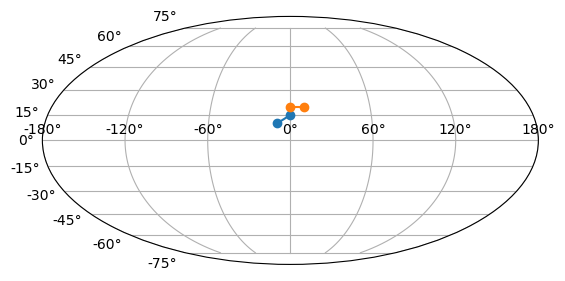

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})

for path in paths:
    adjusted_path = adjust_longitudes(path)
    lons = [p[1] for p in adjusted_path]
    lats = [p[0] for p in adjusted_path]
    ax.plot(np.radians(lons), np.radians(lats), marker='o')

# Set the tick locations and labels for the adjusted longitudes
tick_locs = np.linspace(-np.pi, np.pi, num=7)  # 7 locations for -180°, -120°, -60°, 0°, 60°, 120°, 180°
tick_labels = ['-180°', '-120°', '-60°', '0°', '60°', '120°', '180°']

ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)

ax.grid(True)
plt.show()

In [5]:
df_land = gpd.read_file('data/land_buffered.geojson')

In [4]:
# Define your points and multipolygon obstacle
points = [
    Point(0, 0),
    Point(10, 10),
    # Add more points as needed
]

polygons = [
    Polygon([(2, 2), (8, 2), (8, 8), (2, 8), (2, 2)]),
    # Add more polygons as needed
]

multipolygon = MultiPolygon(polygons)

# Buffer the multipolygon to create detour points
buffer_distance = 1.0  # Adjust this distance as needed
buffered_multipolygon = multipolygon.buffer(buffer_distance)

# Generate points along the buffer boundary
num_points = 100  # Number of points to generate

# Check if the buffered result is a MultiPolygon or a single Polygon
if isinstance(buffered_multipolygon, MultiPolygon):
    buffer_boundary = unary_union([poly.exterior for poly in buffered_multipolygon.geoms])
else:
    buffer_boundary = buffered_multipolygon.exterior

# Generate points along the buffer boundary
step_size = max(1, int(buffer_boundary.length / num_points))
extra_points = [buffer_boundary.interpolate(distance) for distance in range(0, int(buffer_boundary.length), step_size)]

# Ensure the extra points are outside the original multipolygon
extra_points = [pt for pt in extra_points if not multipolygon.contains(pt)]

# Combine original points with extra detour points
all_points = points + extra_points

# Create a function to check if a line intersects the multipolygon
def line_intersects_obstacle(line, multipolygon):
    return line.intersects(multipolygon)

# Create a graph and add edges for each pair of points
G = nx.Graph()

for i, point in enumerate(all_points):
    G.add_node(i, geometry=point)

for i in range(len(all_points)):
    for j in range(i + 1, len(all_points)):
        line = LineString([all_points[i], all_points[j]])
        if not line_intersects_obstacle(line, multipolygon):
            G.add_edge(i, j, weight=all_points[i].distance(all_points[j]), geometry=line)

# Find the shortest path using Dijkstra's algorithm
start_node = 0
end_node = len(points) - 1
shortest_path = nx.dijkstra_path(G, start_node, end_node)

# Extract the geometry of the shortest path
path_geometry = [G.edges[edge]['geometry'] for edge in zip(shortest_path[:-1], shortest_path[1:])]

# Combine line segments into a single line
shortest_path_line = LineString([coord for line in path_geometry for coord in line.coords])

print(shortest_path_line)

LINESTRING (0 0, 1 6, 1 6, 2.4298344215226244 9, 10 10, 2.4298344215226244 9)
